In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from rateCA_local import rateCA_local
import pygame
from physicsCA import min_max

pygame 2.0.1 (SDL 2.0.14, Python 3.9.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# brush properties
r = 20
s = 1

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            # state[:, 0, i, j] = state[:, 1, i, j] + 5.
            state[:, 0, i, j] = 1.
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            # state[:, 0, i, j] = state[:, 1, i, j] - 0.2
            state[:, 0, i, j] = 0.
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), 2)
    
    return cdim_order

def min_max(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

# Test

In [3]:
RADIUS=10

RESX=320
RESY=280

kernel_increment = .2
with torch.no_grad():
    ca = rateCA_local((RESX, RESY), RADIUS=RADIUS).cuda()
    state = ca.initGrid()

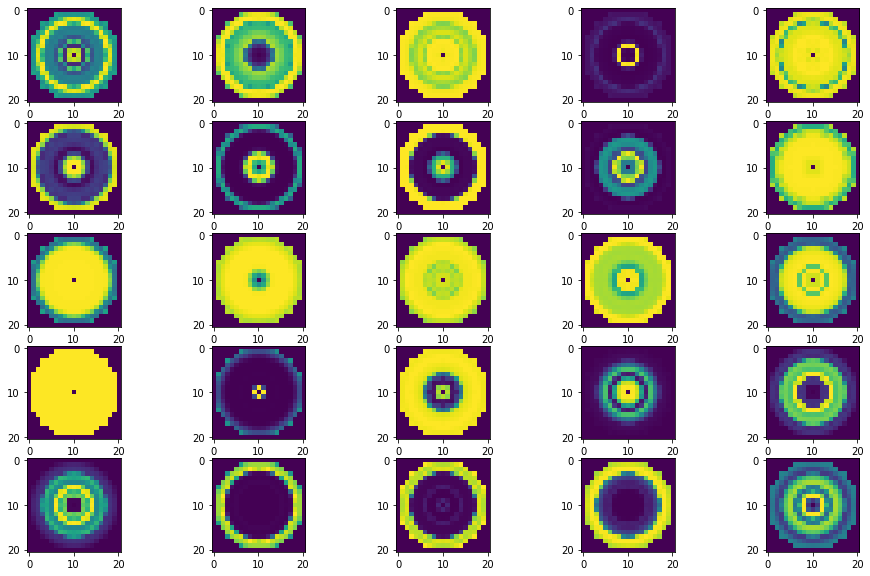

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(16, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(ca.rule.nearest_neighbours.detach().cpu().numpy()[0, :, i*10].reshape(2*RADIUS + 1, 2*RADIUS + 1));

### Init Webcam

In [5]:
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")


In [6]:
ret, web_frame = cap.read()
web_frame = cv2.resize(web_frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
web_frame = cv2.cvtColor(web_frame, cv2.COLOR_BGR2GRAY)

In [7]:
target_file = 'target/pug.png'
# target_file = 'target/stripes.jpg'
# target_file = 'target/diagonal-lines-1.jpg'
# target_file = 'target/checkerboard.jpg'
target_img = Image.open(target_file).convert('L')
target_img = target_img.resize((RESX,RESY), Image.ANTIALIAS)
target_img = np.array(target_img).transpose() / 255.0
# target_img = target_img - target_img.mean()
target_img = torch.cuda.FloatTensor(target_img)
inject_img = False

sign = 1.
t = 0
theta = 0.
X, Y = torch.meshgrid(torch.linspace(-1, 1, RESX), torch.linspace(-1, 1, RESY))

In [8]:
# pygame stuff
######################################
pygame.init()
size = RESX, RESY

win = pygame.display.set_mode((RESX, RESY))

screen = pygame.Surface(size)
UPSCALE = 2
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

# webcam stuff
######################################
inject_webcam = False
wbcam_fx = RESX / web_frame.shape[1]
wbcam_fy = RESY / web_frame.shape[0] #RESY 
img_norm = 1/255. 

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, 6)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################


state = ca.initGrid()
og_kernel = ca.rule.nearest_neighbours
kernel_scale = 1

# inject noise
signal_injection = torch.zeros(size=state.shape)
inject_increment = 1.
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -inject_increment
            if event.type == pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += inject_increment
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_k:
                ca.rule.nearest_neighbours = ca.rule.generate_cppn_kernel() 
                og_kernel = ca.rule.nearest_neighbours
            if event.type == pygame.KEYDOWN and event.key == pygame.K_UP:
                kernel_scale += kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_DOWN:
                kernel_scale -= kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_w:
                inject_webcam = not inject_webcam
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            # toggle plasticity/lr
            if event.type == pygame.KEYDOWN and event.key == pygame.K_o:
                ca.rule.plasticity = not ca.rule.plasticity
            if event.type == pygame.KEYDOWN and event.key == pygame.K_9:
                ca.rule.plastic_lr /= 2.
            if event.type == pygame.KEYDOWN and event.key == pygame.K_0:
                ca.rule.plastic_lr *= 2.
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_EQUALS:
                ca.rule.constant_current *= 2.
                print(ca.rule.constant_current)
            if event.type == pygame.KEYDOWN and event.key == pygame.K_MINUS:
                ca.rule.constant_current /= 2.
                print(ca.rule.constant_current)
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_PAGEUP:
                theta += 0.1
            if event.type == pygame.KEYDOWN and event.key == pygame.K_PAGEDOWN:
                theta -= 0.1
                
                
            # toggle adaptation
            if event.type == pygame.KEYDOWN and event.key == pygame.K_a:
                ca.rule.adaptation = not ca.rule.adaptation
            
            # toggle energy
            if event.type == pygame.KEYDOWN and event.key == pygame.K_n:
                ca.rule.energy = not ca.rule.energy
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid()
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_g:
                inject_img = not inject_img
                ca.noise = not inject_img
                          

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
            
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False

        # nx = state[0, cdim_order[0], :, :].cpu().numpy()
        # nx = nx * 255.
        
        nx = torch.stack([
            state[0, 0, :, :] * (state[0, 1, :, :] < 0.), 
            state[0, 0, :, :] * 0.,
            state[0, 0, :, :] * (state[0, 1, :, :] > 0.)]).cpu().numpy()
        nx = (nx * 255.).transpose(1, 2, 0)
        
        if time_ticking:
            state = ca.forward(state)
            ticker += 1
            
            if inject_webcam:
                ret, frame = cap.read()
                frame = cv2.resize(frame, None, fx=wbcam_fx, fy=wbcam_fy, interpolation=cv2.INTER_AREA)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).transpose()
                # frame = frame - frame.mean()
                frame = torch.cuda.FloatTensor(frame) * img_norm * update_rate
                state[0, 0, 0:frame.shape[0], 0:frame.shape[1]] += frame * 0.05
                
            if inject_img:
                sign = 1.
                state[:, [0], ...] += sign * (target_img.unsqueeze(0).unsqueeze(0) * update_rate) * 0.05
                
                
                # w = 12
                # if (ticker % 20) == 0:
                #     if theta < np.pi/2:
                #         theta = np.pi/2
                #     else:
                #         theta = 0.
                # Z = (update_rate * torch.cos(ticker + w*(np.cos(theta)*X+np.sin(theta)*Y))).unsqueeze(0).unsqueeze(0).cuda()
                # state[:, [0], ...] += (Z * update_rate)
                
    
        if sink and time_ticking:
            xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
            X, Y = torch.meshgrid(xv, yv)
            amp = 0.00
            w = 30
            R = torch.sqrt(X**2 + Y**2).cuda()
            state = torch.where(R > 0.5, state - 0.5 * torch.ones_like(state).cuda(), state)

        if export_imgs and time_ticking:
            imgs.append(nx)
            # imgs.append(state[0, [0, 1, 4, 5], ...].cpu().numpy())
            
        mat_draw = min_max(ca.rule.nearest_neighbours[0, :, RESX*RESY // 2].reshape(2*RADIUS + 1,2*RADIUS + 1).detach()).cpu().numpy()
        connectivity_mat = pygame.transform.scale(pygame.surfarray.make_surface(mat_draw*255.), (50, 50))
        

        pygame.surfarray.blit_array(screen, nx)
        screen.blit(connectivity_mat, (RESX - 50,0))
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        # upscaled_screen.blit(connectivity_mat, (RESX - 50,0))
        pygame.display.flip()
        clock.tick(120)
        
pygame.quit()


0.02
0.04
0.02
0.01
0.005
0.0025
0.00125
0.000625
0.0003125
0.00015625
7.8125e-05
3.90625e-05
7.8125e-05
0.00015625
0.0003125
0.000625
0.00125
0.0025
0.005
0.01
0.02
0.04
0.02
0.01
0.005
0.0025
0.00125
0.000625
0.0003125
0.00015625
7.8125e-05
3.90625e-05
1.953125e-05
9.765625e-06
4.8828125e-06
2.44140625e-06
4.8828125e-06
9.765625e-06
1.953125e-05
3.90625e-05
7.8125e-05
0.00015625
0.0003125
0.000625
0.00125
0.0025
0.00125
0.000625
0.0003125
0.00015625
7.8125e-05
3.90625e-05
1.953125e-05
9.765625e-06
4.8828125e-06
2.44140625e-06
1.220703125e-06
6.103515625e-07
3.0517578125e-07
1.52587890625e-07
7.62939453125e-08
3.814697265625e-08
1.9073486328125e-08
9.5367431640625e-09
4.76837158203125e-09
2.384185791015625e-09
1.1920928955078125e-09
5.960464477539063e-10
2.9802322387695313e-10
1.4901161193847657e-10
7.450580596923828e-11
3.725290298461914e-11
1.862645149230957e-11
9.313225746154785e-12
4.656612873077393e-12
2.3283064365386963e-12
1.1641532182693482e-12
5.820766091346741e-13
2.91038304

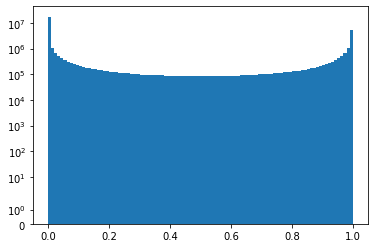

In [9]:
plt.hist(ca.rule.nearest_neighbours.cpu().numpy().reshape(-1), 100); plt.yscale('symlog'); #plt.xscale('log');

In [10]:
ca.rule.constant_current

1.4210854715202004e-16

In [11]:
excite_idx = torch.where(ca.rule.EI.reshape(-1) > 0.)[0].cpu().numpy()
inhib_idx = torch.where(ca.rule.EI.reshape(-1) < 0.)[0].cpu().numpy()

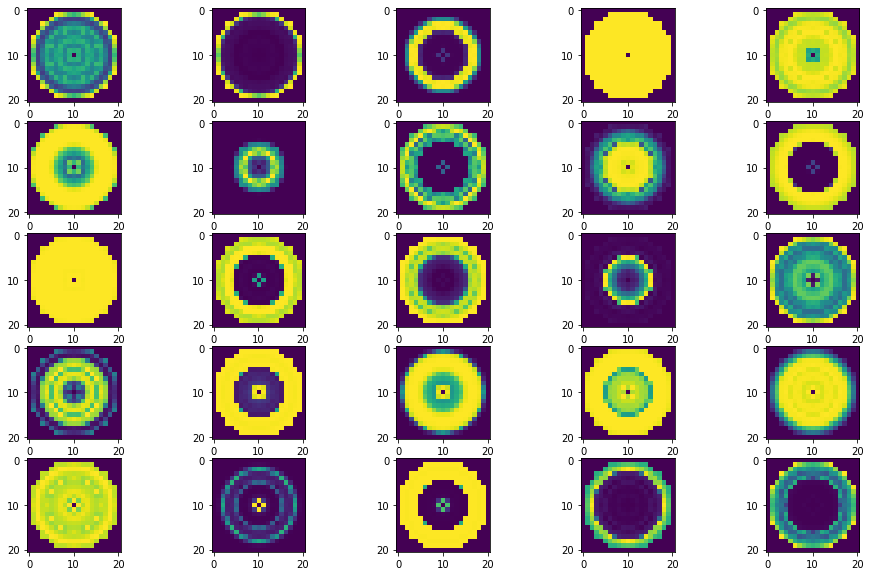

In [12]:
fig, axes = plt.subplots(5, 5, figsize=(16, 10))

rnd_idx = np.random.randint(0, len(excite_idx), 25)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(ca.rule.nearest_neighbours[0, :, rnd_idx[i]].detach().cpu().numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1));

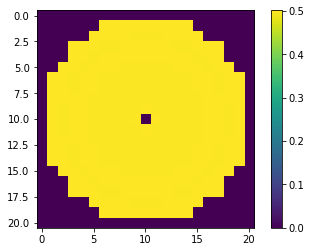

In [13]:
plt.imshow(ca.rule.nearest_neighbours[..., excite_idx].detach().cpu().mean(dim=-1).numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1)); plt.colorbar()

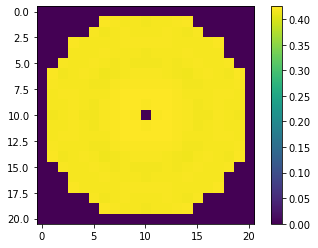

In [14]:
plt.imshow(ca.rule.nearest_neighbours[..., excite_idx].detach().cpu().std(dim=-1).numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1)); plt.colorbar()

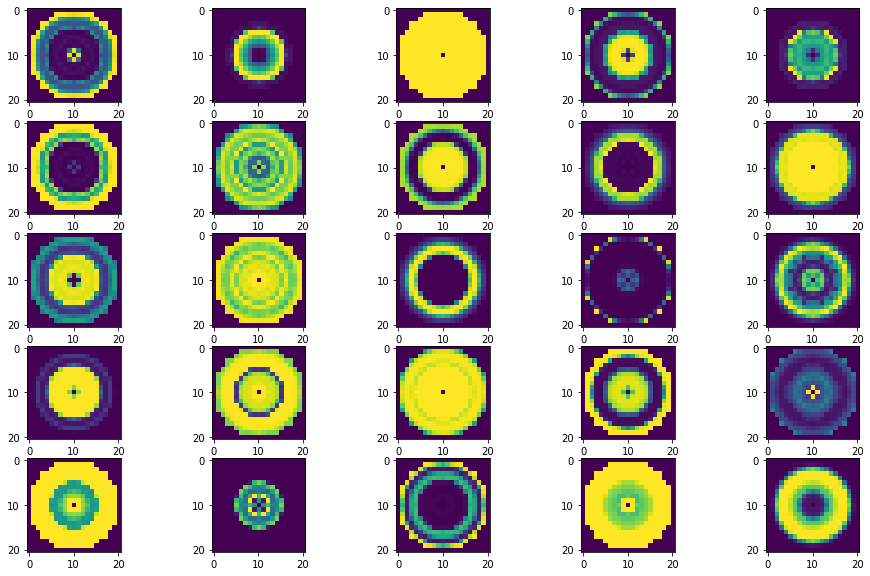

In [15]:
fig, axes = plt.subplots(5, 5, figsize=(16, 10))

rnd_idx = np.random.randint(0, len(inhib_idx), 25)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(ca.rule.nearest_neighbours[0, :, rnd_idx[i]].detach().cpu().numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1));

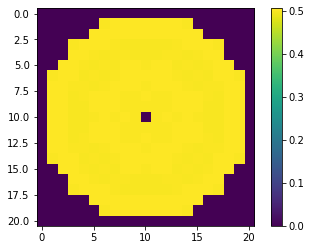

In [16]:
plt.imshow(ca.rule.nearest_neighbours[..., inhib_idx].detach().cpu().mean(dim=-1).numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1)); plt.colorbar()

In [17]:
ca.rule.nearest_neighbours.shape

torch.Size([1, 441, 89600])

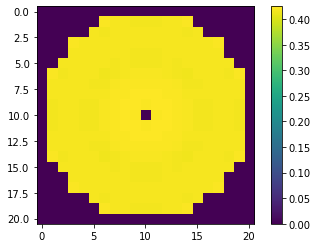

In [18]:
plt.imshow(ca.rule.nearest_neighbours[..., inhib_idx].detach().cpu().std(dim=-1).numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1)); plt.colorbar()

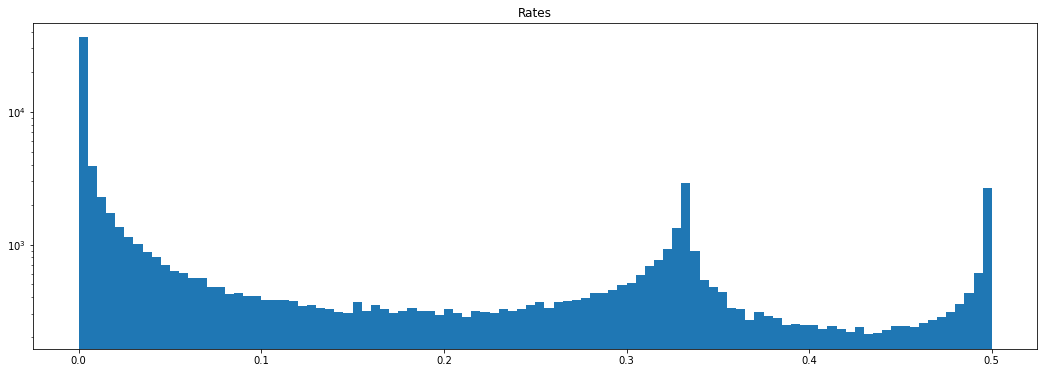

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

axes.hist(state[0, 0].cpu().numpy().reshape(-1), 100);
axes.set_title('Rates'); plt.yscale('log')

In [20]:
state[0, 0].mean()

tensor(0.1286, device='cuda:0')

In [21]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 1)


for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

In [ ]:
conn_canvas = torch.zeros(RESX + 2 * RADIUS, RESY + 2 * RADIUS, 3).cuda()
conn_reshape = ca.rule.nearest_neighbours.reshape(2*RADIUS + 1, 2*RADIUS + 1, RESX, RESY)

for i in tqdm(range(RESX)):
    for j in range(RESY):
        ci = i + RADIUS
        cj = j + RADIUS
        conn_canvas[ci - RADIUS:ci + RADIUS + 1, cj - RADIUS:cj + RADIUS + 1, 0] += conn_reshape[:, :, i, j]
        conn_canvas[ci, cj, 1] += conn_reshape[:, :, i, j].mean()
        conn_canvas[ci, cj, 2] = (np.sign(ca.rule.EI[0, 0, i, j].cpu().numpy()) + 1) / 3 + 1/3

In [ ]:
conn = conn_canvas
conn[:RADIUS,:, :] = conn[:RADIUS,:, :] + conn[-RADIUS:, :, :]
conn[:, :RADIUS, :] = conn[:, :RADIUS, :] + conn[:, -RADIUS:, :]
conn = conn[RADIUS:-RADIUS, RADIUS:-RADIUS, :]

plt.figure(figsize=(20, 10))
plt.imshow(conn[..., 0].cpu().numpy().transpose())

In [ ]:
window = 10
for idx_start in np.arange(0, 400, 50):

    plt.figure(figsize=(12, 12))
    plt.imshow(np.mean(imgs[idx_start:idx_start + window], axis=0).transpose())
    plt.axis('off')
    
    # plt.savefig(f'poster_figs/t_ginger_f{str(idx_start).zfill(3)}.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'poster_figs/ginger_f{str(idx_start).zfill(3)}.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'poster_figs/memory_ginger_f{str(idx_start).zfill(3)}.png', dpi=300, bbox_inches='tight')

In [ ]:
ncol = 2
nrow = 4
fig, axes = plt.subplots(ncol, nrow, figsize=(nrow * 4, ncol * 4))

skip = int(len(imgs) / len(axes.flatten()))
for i, ax in enumerate(axes.flatten()):
    idx = i * skip
    ax.imshow(imgs[idx][0])
    ax.set_xlabel(f't={idx}')
    
plt.tight_layout()

In [ ]:
idx = 285
window = 1


plt.figure(figsize=(16, 5))

params = {'axes.labelsize': 16,
          'axes.titlesize': 24}
plt.rcParams.update(params)

plt.subplot(1, 4, 1)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[0].transpose())
plt.title('Spikes')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[1].transpose())
plt.title('Voltages')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[2].transpose())
plt.title('Thresholds')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[3].transpose())
plt.title('Energy')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')


plt.tight_layout()
#plt.savefig('poster_figs/activity.pdf', bbox_inches='tight', dpi=300)
plt.savefig('poster_figs/activity.png', bbox_inches='tight', dpi=300)

In [ ]:
plt.plot(np.stack(imgs)[:, 0, 1])